# Gathers AkWarm File Inputs for Analysis

Python Kernel

In [151]:
from __future__ import division
import StringIO, gzip, glob, os
import xml.etree.ElementTree as ET
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from statsmodels.formula.api import ols

from IPython.display import display

###################### Matplotlib #######################
# import matplotlib pyplot commands
from matplotlib.pyplot import *

import matplotlib
matplotlib.style.use('ggplot')

# Show Plots in the Notebook
%matplotlib inline


In [152]:
rcParams['figure.figsize'] = (10, 7)
rcParams['font.size'] = 13

In [2]:
# Reads an AkWarm file and returns an XML tree.
def getAkXMLtree(fname):

    res = ''.join( [chr(ord(x) ^ 30) for x in open(fname, 'rb').read()] )
    file_res = StringIO.StringIO(res)
    del res   # to save memory
    zfile = gzip.GzipFile(mode='r', fileobj=file_res)

    # Create the XML tree of the file
    tree = ET.parse(zfile)
    return tree

In [134]:
# Create a dictionary that maps the Reference City ID to the 
# Rating Region
reg_id_to_nm = {
    1: 'Southeast',
    2: 'South Central',
    3: 'Bristol Bay',
    4: 'Interior/YKK',
    5: 'Northwest',
    6: 'Arctic Slope',
}

city_to_region = {}
for lin in open('city_to_region.txt'):
    flds = lin.split('\t')
    if len(flds)==2:
        city_to_region[int(flds[0])] = reg_id_to_nm[int(flds[1])]
        
# List of City IDs that are Special Hydro
special_hydro = (188,195,200,201,202,204,207,209,210,214,216,217,227,286,287,292,301)

In [136]:
# Returns data extracted from an AkWarm file with the file name of 'fname'.
def getFileData(fname):

    # the result is a dictionary with the data for this home.
    res = {}
    
    res['FileName'] = os.path.basename(fname)
    
    # Get root of XML docmument, the Project object.
    pr = getAkXMLtree(fname).getroot()
    
    # convenience functions for extracting float and integer values
    def getFloat(thePath):
        return float(pr.find(thePath).text)

    def getInt(thePath):
        return int(pr.find(thePath).text)

    def getStr(thePath):
        return pr.find(thePath).text

    # The reference City
    City_ID = getInt('Hm/HmInputs/ReferenceCity')
    res['City_ID'] = City_ID
    
    res['Rating_Region'] = city_to_region[City_ID]

    # Variables concerning special hydro treatment
    pri_htg_fuel = pr.findall('Hm/HmInputs/SpaceHeaters/Heater/Fuel')[0].text
    res['Is_Special_Space'] = 1 if pri_htg_fuel=='Electric' and (City_ID in special_hydro) else 0
    dhw_fuel = pr.findall('Hm/HmInputs/DHWheaters/DHWheater/Fuel')[0].text
    res['Is_Special_DHW'] = 1 if dhw_fuel=='Electric' and (City_ID in special_hydro) else 0
    
    res['VentType'] = getStr('Hm/HmInputs/VentType')
    res['EnBlowerTestOrEst'] = getStr('Hm/HmInputs/EnBlowerTestOrEst')

    # AFUE values for primary heating system
    entered_AFUE = float(pr.findall('Hm/HmInputs/SpaceHeaters/Heater/AFUE')[0].text)
    default_AFUE = float(pr.findall('Hm/HmInputs/SpaceHeaters/Heater/Output/AFUEdefault')[0].text)
    res['AFUE_final_primary'] = entered_AFUE if entered_AFUE > 0.0 else default_AFUE

    # Secondary Heating info
    res['HeatingFuel_Secondary'] = pr.findall('Hm/HmInputs/SpaceHeaters/Heater/Fuel')[1].text
    res['Has_Secondary_Htr'] = 'Yes' if res['HeatingFuel_Secondary'] != 'None' else 'No'
    if res['Has_Secondary_Htr'] == 'Yes':
        entered_AFUE = float(pr.findall('Hm/HmInputs/SpaceHeaters/Heater/AFUE')[1].text)
        default_AFUE = float(pr.findall('Hm/HmInputs/SpaceHeaters/Heater/Output/AFUEdefault')[1].text)
        res['AFUE_final_secondary'] = entered_AFUE if entered_AFUE > 0.0 else default_AFUE
    
    # Overall Heating and DHW efficiencies
    res['HtgSysEffic'] = getFloat('Hm/EnrgResults/HtgSysEffic')
    res['DHWenergyFactor'] = getFloat('Hm/EnrgResults/DHWenergyFactor')
    
    # Record the Garage Size, and car count per unit floor area
    res['Garage_Car_Count'] = getInt('Hm/EnrgResults/GarageSize')

    res['WinWallRatio'] = getFloat('Hm/EnrgResults/WinWallRatio')
    res['SouthWinArea'] = getFloat('Hm/EnrgResults/SouthWinArea')
    res['NaturalACH'] =  getFloat('Hm/EnrgResults/NaturalACH')
      
    return res

In [137]:
# Process the hm2 files (can't handle the .hom files)
recs = []
ct = 0
for fn in glob.glob('../1700 AkWarm Files/*.hm2'):
    ct += 1
    if ct % 50 == 0: print ct
    try:
        recs.append(getFileData(fn))
    except:
        print 'Error processing %s' % fn
df1 = pd.DataFrame(recs)
df1.head()

50
100
150
200
250
300
350
400
450
500
550
Error processing ../1700 AkWarm Files\DaveJohnsonrecreated11340.hm2
Error processing ../1700 AkWarm Files\DavidTracyBuntsrecreated11800.hm2
600
Error processing ../1700 AkWarm Files\DoriMcDannoldrecreated11155.hm2
650
700
750
800
Error processing ../1700 AkWarm Files\HQBrecreated10174.hm2
Error processing ../1700 AkWarm Files\JeffReichelrecreated11685.hm2
850
900
950
Error processing ../1700 AkWarm Files\MarkGreerrecreated10430.hm2
Error processing ../1700 AkWarm Files\MarthaNicholairecreated10987.hm2
Error processing ../1700 AkWarm Files\MARYBRITTrecreated11597.hm2
1000
1050
1100
Error processing ../1700 AkWarm Files\PetersenGroupInc.recreated10563.hm2
Error processing ../1700 AkWarm Files\PetersenGroupInc.recreated10564.hm2
1150
1200
1250
1300
Error processing ../1700 AkWarm Files\StevenWirtanenrecreated11298.hm2
1350
Error processing ../1700 AkWarm Files\ThorRyanrecreated11820.hm2
1400
1450


,AFUE_final_primary,AFUE_final_secondary,City_ID,DHWenergyFactor,EnBlowerTestOrEst,FileName,Garage_Car_Count,Has_Secondary_Htr,HeatingFuel_Secondary,HtgSysEffic,Is_Special_DHW,Is_Special_Space,NaturalACH,Rating_Region,SouthWinArea,VentType,WinWallRatio
0,85,NaN,293,0.80,From_Blower_Test,0078DD.hm2,0,No,None,0.85,0,0,0.201408,Interior/YKK,127.6800,None,0.119377
1,86,NaN,293,0.70,From_Blower_Test,0084BHP.hm2,4,No,None,0.90,0,0,0.298001,Interior/YKK,181.3500,None,0.098444
2,70,63,295,0.76,From_Blower_Test,01005P.hm2,0,Yes,Spruce,0.74,0,0,0.304525,Bristol Bay,60.3753,None,0.140288
3,82,63,295,0.70,From_Blower_Test,01006P.hm2,0,Yes,Spruce,0.82,0,0,0.136446,Bristol Bay,67.9600,HRV,0.105057
4,82,85,295,0.70,From_Blower_Test,01016P.hm2,0,Yes,Oil_No_1,0.80,0,0,0.117657,Bristol Bay,99.7300,HRV,0.108298


In [138]:
df2 = pd.read_csv('iecc_data.csv')
df = pd.merge(df1, df2)
df.to_csv('final_iecc.csv', index=False)
df.head()

,AFUE_final_primary,AFUE_final_secondary,City_ID,DHWenergyFactor,EnBlowerTestOrEst,FileName,Garage_Car_Count,Has_Secondary_Htr,HeatingFuel_Secondary,HtgSysEffic,...,RatingDate,RaterName,UserAFUE,FloorArea,GarageArea,HeatingFuel,DHWFuel,EvaluatedFloorArea,EvaluatedGarageArea,AkWarm-HERS difference
0,85.0,NaN,293,0.80,From_Blower_Test,0078DD.hm2,0,No,None,0.850,...,2009-12-07T13:28:00,Karl Hough 102,85.0,1522,0,Oil_No_2,Propane,1522.0000,0.0,34.6
1,82.0,63,295,0.70,From_Blower_Test,01006P.hm2,0,Yes,Spruce,0.820,...,2010-03-03T11:09:00,John Kurtz,0.0,1215,0,Oil_No_1,Oil_No_1,1215.0000,0.0,51.6
2,82.0,85,295,0.70,From_Blower_Test,01016P.hm2,0,Yes,Oil_No_1,0.800,...,2009-04-03T15:20:24.40625-08:00,Nick Smeaton,0.0,26.83*44.67,0,Oil_No_1,Oil_No_1,1198.4961,0.0,55.0
3,86.3,NaN,293,0.70,From_Blower_Test,0103DPP.hm2,2,No,None,0.875,...,2010-05-19T10:30:00,Karl Hough,86.3,4600,386.9,Oil_No_2,Oil_No_2,4600.0000,386.9,45.0
4,95.0,NaN,1,0.65,From_Blower_Test,011314mh.hm2,4,No,None,0.950,...,2014-01-13T18:49:24,Jesse Bennett 116,95.0,1302~1812,938,Natural_Gas,Natural_Gas,3114.0000,938.0,48.6


In [139]:
cols = list(df.columns)
cols.sort()
cols

['AFUE_final_primary',
 'AFUE_final_secondary',
 'AkWarm-HERS difference',
 'Batch',
 'City_ID',
 'DHWFuel',
 'DHWenergyFactor',
 'ElectricUse',
 'EnBlowerTestOrEst',
 'EnergyCost',
 'EvaluatedFloorArea',
 'EvaluatedGarageArea',
 'FileName',
 'FloorArea',
 'GarageArea',
 'Garage_Car_Count',
 'HERSScore',
 'Has_Secondary_Htr',
 'HeatingFuel',
 'HeatingFuel_Secondary',
 'HomeAddress',
 'HomeCity',
 'HouseType',
 'HtgSysEffic',
 'ID',
 'IECCEnvelopeSavingsFract',
 'IECCSavingsFract',
 'Is_Special_DHW',
 'Is_Special_Space',
 'NaturalACH',
 'RaterName',
 'RatingDate',
 'RatingPoints',
 'Rating_Region',
 'Result',
 'SavingsAnnual',
 'SouthWinArea',
 'UserAFUE',
 'VentType',
 'WinWallRatio']

In [156]:
def analyze(query_string):
    df_plot = df.query(query_string)
    df_plot.plot(kind='scatter', x='RatingPoints', y='HERSScore')
    xlim(80,100)
    ylim(0, 100);
    display(gcf())
    clf();
    print 'Max HERS Score: %.0f' % max(df_plot.HERSScore)
    mod = ols(formula='HERSScore ~ RatingPoints', data=df_plot)
    res = mod.fit()
    print 'AkWarm Points -> HERS Score R-squared: %.2f' % res.rsquared
    print
    print '% of Ratings at this Point Level with HERS Score <= 50'
    for pts in range(84, 98):
        scores = df_plot[(df_plot.RatingPoints > pts - 0.5) & (df_plot.RatingPoints < pts + 0.5)].HERSScore
        if len(scores)==0: continue    # no ratings in this band
        pct_qual = 100.0 * len(scores[scores <= 50.0])/len(scores)
        print '   %d points: %.1f %%' % (pts, pct_qual)


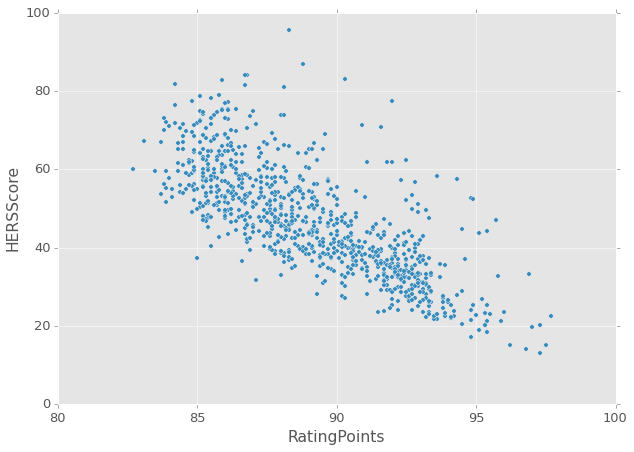

Max HERS Score: 96
AkWarm Points -> HERS Score R-squared: 0.57

% of Ratings at this Point Level with HERS Score <= 50
   84 points: 0.0 %
   85 points: 13.2 %
   86 points: 15.1 %
   87 points: 36.6 %
   88 points: 60.7 %
   89 points: 59.5 %
   90 points: 82.9 %
   91 points: 92.5 %
   92 points: 94.3 %
   93 points: 96.6 %
   94 points: 90.9 %
   95 points: 88.9 %
   96 points: 100.0 %
   97 points: 100.0 %


In [157]:
analyze("Has_Secondary_Htr=='No'")

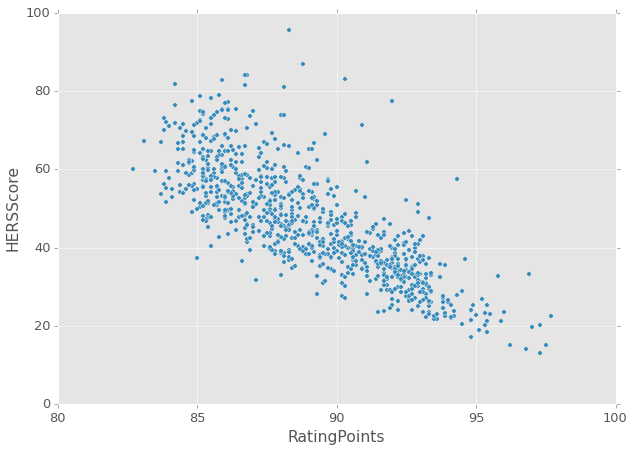

Max HERS Score: 96
AkWarm Points -> HERS Score R-squared: 0.63

% of Ratings at this Point Level with HERS Score <= 50
   84 points: 0.0 %
   85 points: 13.2 %
   86 points: 15.4 %
   87 points: 36.6 %
   88 points: 60.4 %
   89 points: 61.0 %
   90 points: 84.1 %
   91 points: 92.5 %
   92 points: 98.8 %
   93 points: 98.8 %
   94 points: 95.2 %
   95 points: 100.0 %
   96 points: 100.0 %
   97 points: 100.0 %


In [158]:
analyze("Has_Secondary_Htr=='No' and EnBlowerTestOrEst=='From_Blower_Test'")

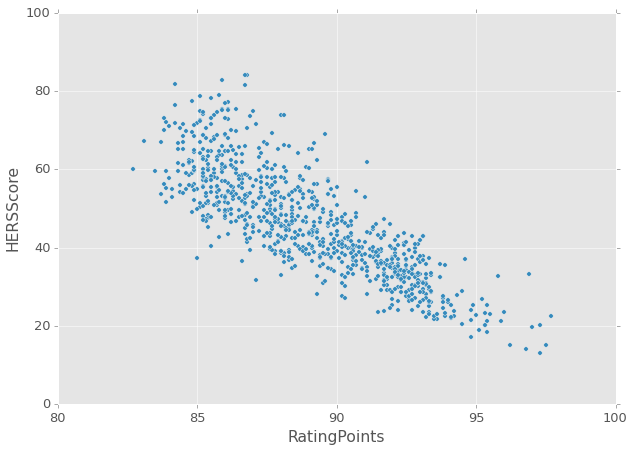

Max HERS Score: 84
AkWarm Points -> HERS Score R-squared: 0.68

% of Ratings at this Point Level with HERS Score <= 50
   84 points: 0.0 %
   85 points: 13.2 %
   86 points: 14.4 %
   87 points: 36.6 %
   88 points: 62.1 %
   89 points: 61.8 %
   90 points: 85.3 %
   91 points: 94.2 %
   92 points: 100.0 %
   93 points: 100.0 %
   94 points: 100.0 %
   95 points: 100.0 %
   96 points: 100.0 %
   97 points: 100.0 %


In [160]:
analyze("Has_Secondary_Htr=='No' and EnBlowerTestOrEst=='From_Blower_Test' and Is_Special_DHW==0")